# Machine learning for free energy functional for 1D Lennard Jones fluid
## -Traning part

In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from timeit import default_timer as timer

#speed improve, useless if parrallel activate
from numba import jit

#use pymp for parrallel, if no pymp then switch to "ML_kernel_single" 
#num_thread = number of cpu 

import pymp
num_thread = 8

print()

In [2]:
# none = change mu and epsilon
# fix_mu_T = fix mu and epsilon
# fuzzy = less accuracy, higher resolution 

#file_dir = "_fix_mu_T"
file_dir = "_fuzzy"


In [3]:
# load simulation parameters
# L - system box size
# dx - spacing 
# N - grid points
# batch_size - number of samples

f = open('LJ_data'+file_dir+'/MC_parameter.dat', 'r')
temp = f.read().split("\t")
L=float(temp[0])
dx=float(temp[1])
N=int(L/dx)
batch_size = int(temp[2])
f.close()

In [4]:
print(str(dx)+"\t"+str(L)+"\t"+str(batch_size))

0.03125	32.0	256


In [5]:
# assign mini batch size 32 or 64 seems good
mini_batch = 32

In [6]:
# force batch_size/mini_batch be integer

f = open('LJ_data'+file_dir+'/MC_inform.dat', 'r')
MC_inform = f.read().splitlines()
for i in range(len(MC_inform)):
    #print(MC_inform[i])
    MC_inform[i]=MC_inform[i].split("\t")
f.close()
batch_size = (len(MC_inform)//mini_batch)*mini_batch

In [7]:
print(str(dx)+"\t"+str(N)+"\t"+str(L)+"\t"+str(batch_size))

0.03125	1024	32.0	256


In [8]:
MC_inform = np.array(MC_inform)
MC_inform = MC_inform.astype(float)

In [9]:
##
# ML parameters
# Nw - number of kernels
# Lw - cutoff length of kernels 
# LLw - cutoff length of kernels /2
# grid points of Lw must be odd number, so convolution can be centered

Nw = 8
Lw = int(np.floor(8/dx)+1)
LLw = int(np.floor(8/dx)/2)
Lw*dx

8.03125

In [10]:
#test for loading 
# rho -> density profile
# rho0 -> reservar density
# mu -> chemical potential
# Vext -> external potential

rho_array = np.zeros((mini_batch,N))
rho0_array = np.zeros((mini_batch))
epsilon_array = np.zeros((mini_batch))
mu_array = np.zeros((mini_batch))
Vext_array = np.zeros((mini_batch,N))


In [11]:
# initial kernel by noise, force beta symmetry

"""initial w"""
def initial_kernel():
    
    np.random.seed(0)
    w = np.random.normal(0,1,Nw*Lw)*0.01
    w=w.reshape((Nw,Lw))
    
    np.random.seed(1)
    beta1 = np.random.normal(0,1,Nw**2)*0.01
    beta1=beta1.reshape((Nw,Nw))
    beta1=0.5*(beta1+np.transpose(beta1))#must sysmetry
    #beta1[0][0]=1
    return w,beta1

In [12]:
w,beta1 = initial_kernel()
print(beta1[0],beta1[1])

[ 0.01624345 -0.00146359 -0.003503   -0.00086056  0.00089117 -0.01246687
  0.00932485  0.00038888] [-0.00146359 -0.0024937   0.00292125 -0.01371934 -0.00583811 -0.00635842
  0.00875486 -0.00084395]


In [13]:
"""load data with shuffle"""
# for stochastic load,i.e. load random 
# mini_batch in all samples, just to speedup gradient descent

@jit
def load_data (batch_number):
    for j in range(mini_batch):
        i = batch_number[j]
        
        rho_array[j]=np.loadtxt("LJ_data"+file_dir+"/rho_"+str(i)+".dat")
        #rho_array[j]=(rho_array[j]+rho_array[j][::-1])/2 #force symmetry ? 
        
        Vext_array[j]=np.loadtxt("LJ_data"+file_dir+"/Vext_"+str(i)+".dat")
        epsilon_array[j]=float(MC_inform[i][1])
        mu_array[j]=np.log(float(MC_inform[i][2]))
        
    return rho_array,Vext_array,epsilon_array,mu_array

In [14]:
# convolution (cross correltion) in 1d 
# with periodic boundary condition

@jit
def conv (rho,w):

    rho_pad=np.pad(rho,(LLw,LLw),'symmetric')
    rho_pad[0:LLw]=rho_pad[N:N+LLw]
    rho_pad[N+LLw:N+LLw*2]=rho_pad[LLw:LLw+LLw]
    n = np.correlate(rho_pad,w)
    
    return n*dx

## Hard rod

$\cal F^{\rm HR}= - \int n_0\ln(1-n_1) dx$

$n_i(x)=\int\rho(x^\prime)\omega^{\rm hr}_i(x-x^\prime) dx^{\prime}$ $\rightarrow$ convolution 

$\omega^{\rm hr}_0(x)=\frac{1}{2}\delta(R-|x|)$ 

$\omega^{\rm hr}_1(x)=\theta(R-|x|)$


$R=\frac{1}{2}\sigma$

$c_1=\frac{\delta F^{exc}}{\delta \rho}$

## Convolution and fourier transform
Convolution usually computed in Fouier space due to the computational cost 
$$f\otimes g=\int f(x^\prime) g(x-x^\prime) dx^{\prime}$$
with $\otimes$ denoting convolution, and 
$$\mathscr{F}[f\otimes g]=\mathscr{F}[f]\cdot\mathscr{F}[g]$$

For our work, it is useful to calculate the analytical expression of $\omega_0^{\rm hr}$ and $\omega_1^{\rm hr}$ in the frequency domain 
$$\mathscr{F}[\omega^{\rm hr}_0]=\cos(k R)$$
$$\mathscr{F}[\omega^{\rm hr}_1]=\frac{2\sin(k R)}{k}$$ 

In [15]:
# 1d FMT kernel
@jit
def w_FMT(eps):
    #d=cal_eff_diameter (eps)
    R = 1.0/2
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

@jit
def cal_c1_FMT(rho,eps):
    w0,w1 = w_FMT(eps)
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)
    
    

## combine free enegy functional of HR and ML
$\cal F^{\rm exc}=\cal F^{\rm HR}+\cal F^{\rm ML}$

$c_1=\frac{\delta F^{exc}}{\delta \rho}=\frac{\delta F^{ML}+F^{HR}}{\delta \rho}$

$\frac{\delta \cal F^{\rm HR}}{\delta\rho} = -\ln(1-n_1) \otimes \omega^{\rm hr}_0 + \frac{n_0}{1-n_1} \otimes \omega^{\rm hr}_1$

$\cal F^{\rm ML}=\epsilon\sum_{ij} \beta_{ij} n_i n_j$

$\frac{\delta \cal F^{\rm ML}}{\delta\rho}=\epsilon\sum_{ij} \beta_{ij} (n_i \otimes \omega_j + n_j \otimes \omega_i)$

In [16]:
# compute c1 

@jit
def cal_c1(beta,eps,n,w,rho):
    c1 = np.zeros((N))
    for i in range(Nw):
        for j in range(Nw):
            c1+=eps*beta[i][j]*(conv(n[i],w[j])+conv(n[j],w[i]))
    c1+=cal_c1_FMT(rho,eps)
    return c1

#### $\rho^{ML} = \exp(\mu-c_1-V_{ext})$

In [17]:
#determine z=exp(mu) by minimize distance between rho^{ML} and rho^{simulation}
#return mu = ln(z)
@jit
def f (rho,c,rhoML):
    return np.sum((rho-c*rhoML)**2)

@jit
def cal_mu_ML(rho,c1,Vext):
    rhoML = np.exp(-c1-Vext)
    mu_guess = np.zeros(3)
    res = np.zeros(3)
    
    for i in range(3):
        mu_guess[i] = i-1.0
    interval = 1
    
    for iteration in range (1000):
        for i in range(3):
            res[i] = f(rho,mu_guess[i],rhoML)
        if(res[0]>res[1] and res[2]>res[1]):
            interval/=2
            mu_guess[0]=mu_guess[1]-interval
            mu_guess[2]=mu_guess[1]+interval
        elif(res[1]>res[0] and res[2]>res[0]):
            temp = mu_guess[0]
            mu_guess[0]=temp-interval
            mu_guess[1]=temp
            mu_guess[2]=temp+interval
        else:
            temp = mu_guess[2]
            mu_guess[0]=temp-interval
            mu_guess[1]=temp
            mu_guess[2]=temp+interval
        if(interval<10**-8):
            break
    #print("mu guess",mu_guess[1],1.5)
    #print(np.log(mu_guess[1]),mu_guess[1])
    return np.log(mu_guess[1])
            
    
     

determine reservoir density $\rho_0$ by 

$\mu = c_1 + \ln(\rho_0)$


$c_1=\frac{\delta F^{exc}}{\delta \rho}=\frac{\delta F^{ML}+F^{HR}}{\delta \rho}|_{\rho=\rho_0}$


In [18]:
@jit
def f2 (c1,x,mu,eps):
    rho_temp = np.full(N,x)
    c1_FMT = cal_c1_FMT(rho_temp,eps)[0]
    return (c1*x+np.log(x)+c1_FMT-mu)**2

@jit
def cal_rho0(mu,w,beta,eps):
    
    c1=0  
    for i in range(Nw):
        for j in range(Nw):
            c1+=eps*beta[i][j]*(np.sum(np.sum(w[i])*w[j]))*dx**2*2

    rho_guess = np.zeros(3)
    res = np.zeros(3)
    interval = 0.01

    for i in range(3):
        rho_guess[i] = 0.3+interval*i
        
    for iteration in range (10000):
        for i in range(3):
            res[i] = f2(c1,rho_guess[i],mu,eps)
        if(res[0]>res[1] and res[2]>res[1]):
            interval/=2
            rho_guess[0]=rho_guess[1]-interval
            rho_guess[2]=rho_guess[1]+interval
        elif(res[1]>res[0] and res[2]>res[0]):
            temp = rho_guess[0]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
        else:
            temp = rho_guess[2]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
            
        if(rho_guess[0]<0 or rho_guess[2]>1):
            break
        if(interval<10**-8):
            #print(rho_guess[1],iteration)
            break        
    
    temp=rho_guess[1]
    if(temp<=0):
        return 0.1
    elif(temp>1):
        return 0.9
    else:
        return rho_guess[1]

#### $\rho^{ML} = \exp(\mu-c_1-V_{ext})$

In [19]:
@jit
def cal_rho_ML(mu,c1,V):
    rho_ML = np.exp(-c1-V+mu)
    return rho_ML

Cost function $J=\sum \int(\rho_{sim}-\rho_{ML})^2$

In [20]:
@jit
def error (rho,rho_ML):
    return np.sum((rho-rho_ML)**2)*dx


Determine $\frac{\partial J}{\partial \beta}$
$$
\frac{\partial J}{\partial \beta_{ij}}=-2\sum_{k=1}^{M} \int_0^L (\rho^{sim}_{k}-\rho^{ML}_{k})\rho^{ML}_{k} \left(\frac{\partial \mu_k^{ML}}{\partial \beta_{ij}} - n_{k,i}\otimes \omega_j-n_{k,j}\otimes \omega_i\right)dx 
$$

In [21]:
@jit
def Dbeta_tot(rho_ML,rho,rho0,eps,n,w,i,j):
    temp=np.zeros((N))    
    for k in range(mini_batch):
        c1=(np.sum(np.sum(rho0[k]*w[i])*w[j]))*2*dx**2  
        temp+=(2.0)*(rho_ML[k]-rho[k])*rho_ML[k]*eps[k]*(c1-conv(n[k][i],w[j])-conv(n[k][j],w[i]))
    
    return np.sum(temp)*dx

Determine $\frac{\delta J}{\delta \omega}$
$$
\frac{\delta J}{\delta \omega_{i}(x^{\prime})} = -8\left\lbrace\sum_{k=1}^{M} \int_0^L dx\, (\rho^{sim}_{k}-\rho^{ml}_{k}) \rho^{ml}_{k}  \epsilon_k\sum_j \beta_{ij}  \left( n^0_{k,j} -n_{k,j}(x+x^{\prime})\right)\right\rbrace 
$$

say $ m=n \otimes \omega $

$m[i]=\sum_{j=-LLw}^{LLw} n[i+j]\omega[j] $

if $\omega[j] \rightarrow \omega[j]+\Delta \omega[j]$

$\Delta m[i]=n[i+j]\Delta\omega[j] $

$\Rightarrow \frac{\delta m}{\delta \omega[j]}[i]=n[i+j]$

In [22]:
# rhow[ith kernel][position]
@jit
def DwF(rhow,beta,j):
    temp=np.zeros((N))
    for i in range(Nw):
        temp+=rhow[i]*beta[i][j]
    return temp

@jit
def Dwmu(beta,rho0,w,j):
    c1=0
    for i in range(Nw):
        c1+=4*(beta[i][j])*(np.sum(rho0*w[i]))*dx**2
    return c1

# rhow[ith sample][shifted distance][ith kernel][position]
@jit
def Dw_tot(rho_ML,rho,rho0,rhow,j,p,beta,eps,w):
    temp=np.zeros(mini_batch)
    for k in range(mini_batch): 
        temp[k]=np.sum((rho_ML[k]-rho[k])*(2)*rho_ML[k]*eps[k]*(
            Dwmu(beta,rho0[k],w,j)-DwF(rhow[k][p],beta,j)))
    #print(temp)
    return np.sum(temp)*dx

In [23]:
# n_array[ith kernel][position]
# rhow[shifted distance][ith kernel][position]

# n_array[k] -> rho[k] conv w[k]
# shifted n by -LLw to LLw to speedup

@jit
def kernel_rhow(n_array,w):
    rhow = np.zeros((Lw,Nw,N))
    for k in range(Nw):
        for p in range(Lw):
            rhow[p][k]=np.roll(n_array[k],-(p-LLw))*dx*4
    return rhow

In [24]:
## single cpu
def ML_kernel_single(seed,w,beta,alpha):
    
    ### initial seed 
    ### batch array = [0,1,2....number of samples] then shuffle
    np.random.seed(seed)
    batch_number=np.arange(batch_size)
    np.random.shuffle(batch_number)
    
    ### initial array 
    dbeta = np.zeros((beta.shape))
    dw = np.zeros((w.shape))
    
    rhoML_array = np.zeros((mini_batch,N))
    rho0ML_array = np.zeros((mini_batch))
    n_array = np.zeros([mini_batch,Nw,N])
    rhow = np.zeros((mini_batch,Lw,Nw,N))

    # epco = epoch
    # typo in the very beginning, too lazy to change
    # epco_error will sum all minibatch error
    
    epco_error = 0
    
    for M in range(int(batch_size/mini_batch)):
        #load simulation data
        #print(str(M)+'/'+str(batch_size/mini_batch))
        rho_array,Vext_array,epsilon_array,mu_array=load_data (
            batch_number[M*mini_batch:(M+1)*mini_batch])
        
        # n = rho conv w
        for MM in range(mini_batch):
            for j in range (Nw):
                n_array[MM][j] = conv(rho_array[MM],w[j])

        # prepare c1,mu,rho0 and rhoML. The ingredients for learning
        for MM in range(mini_batch):
            c1 = cal_c1(beta,epsilon_array[MM],n_array[MM],w,
                        rho_array[MM])
            mu_ML=cal_mu_ML(rho_array[MM],c1,Vext_array[MM])
            rho0ML_array[MM]=cal_rho0(mu_ML,w,beta,
                                      epsilon_array[MM])
            rhoML_array[MM] = cal_rho_ML(mu_ML,c1,Vext_array[MM])

        
        epco_error+=error(rho_array,rhoML_array)
        
        #dbeta=dJ/dbeta 
        #in purpose to run all ij, check sysmmetry after training 
        for i in range(Nw):
            for j in range(Nw):
                dbeta[i][j] = Dbeta_tot(rhoML_array,rho_array,rho0ML_array
                                        ,epsilon_array,n_array,w,i,j)
        #shift n 
        #n[ith rho][ith kernel][position]
        #rhow[ith rho][shifted distance][ith kernel][position]
        for i in range(mini_batch):
            rhow[i]=kernel_rhow(n_array[i],w)
            
        #dw=dJ/dw 
        for j in range(Nw):
            for p in range(Lw):
                dw[j][p]=Dw_tot(rhoML_array,rho_array,rho0ML_array,rhow,j,p,beta,epsilon_array,w)
                
        #update w and beta 
        w-=alpha*dw
        beta-=alpha*dbeta
        # regulation seems dosen't matter
        #w *=(1-10**(-14)) 
        #beta *=(1-10**(-14))
    return w,beta,epco_error

In [25]:
## pymp 
def ML_kernel(seed,w,beta,alpha):
### initial array     
    np.random.seed(seed)
    batch_number=np.arange(batch_size)
    np.random.shuffle(batch_number)
    
    dbeta = pymp.shared.array((beta.shape), dtype='float')
    dw = pymp.shared.array((w.shape), dtype='float')
    
    rhoML_array = pymp.shared.array((mini_batch,N), dtype='float')
    rho0ML_array = pymp.shared.array((mini_batch), dtype='float')
    n_array = pymp.shared.array((mini_batch,Nw,N), dtype='float')
    rhow = pymp.shared.array((mini_batch,Lw,Nw,N), dtype='float')

    epco_error = 0
    N_minbatch = int(batch_size/mini_batch)
    #print("AAA")
    for M in range(int(batch_size/mini_batch)):
        #print(str(M)+'/'+str(batch_size/mini_batch))
        rho_array,Vext_array,epsilon_array,mu_array=load_data (
            batch_number[M*mini_batch:(M+1)*mini_batch])
        
        with pymp.Parallel(num_thread) as p:
            for MM in p.range(mini_batch):
                for j in range (Nw):
                    n_array[MM][j] = conv(rho_array[MM],w[j])

        with pymp.Parallel(num_thread) as p:            
            for MM in p.range(mini_batch):
                c1 = cal_c1(beta,epsilon_array[MM],n_array[MM],w,
                            rho_array[MM])
                mu_ML=cal_mu_ML(rho_array[MM],c1,Vext_array[MM])
                #print(mu_array[MM],mu_ML)
                #mu_array[MM]=np.log(np.sum(rho_array[MM])/np.sum(np.exp(-c1-Vext_array[MM])))
                rho0ML_array[MM]=cal_rho0(mu_ML,w,beta,
                                          epsilon_array[MM])
                rhoML_array[MM] = cal_rho_ML(mu_ML,c1,Vext_array[MM])

        epco_error+=error(rho_array,rhoML_array)
        
        #if(np.isnan(epco_error)):
        #    return w,beta,epco_error
        
        with pymp.Parallel(num_thread) as p:            
            for i in p.range(Nw):
                for j in range(Nw):
                    dbeta[i][j] = Dbeta_tot(rhoML_array,rho_array,rho0ML_array
                                            ,epsilon_array,n_array,w,i,j)
                    #print(dbeta[i][j])
        
        with pymp.Parallel(num_thread) as p:            
            for i in p.range(mini_batch):
                rhow[i]=kernel_rhow(n_array[i],w)

        with pymp.Parallel(num_thread) as pp:            
            for j in pp.range(Nw):
                for p in range(Lw):
                    dw[j][p]=Dw_tot(rhoML_array,rho_array,rho0ML_array,rhow,j,p,beta,epsilon_array,w)
        w-=alpha*dw
        beta-=alpha*dbeta
        #w *=(1-10**(-14)) 
        #beta *=(1-10**(-14))
    return w,beta,epco_error
print()

In [26]:
def save_data(w,beta,error_array):
    
    """save kernel results"""
    np.savetxt(r"./ML_data/epco_error_sq.txt",error_array)
    np.savetxt(r"./ML_data/w_kernel_sq.txt",w)
    np.savetxt(r"./ML_data/beta_kernel_sq.txt",beta)
    
    f = open('./ML_data/parameter_kernel_sq.txt', 'w')
    f.write(str(dx))
    f.write("\n")
    f.write(str(Lw))
    f.write("\n")
    f.write(str(Nw))
    f.write("\n")
    f.close()
    """save done"""

In [27]:
np.random.seed(10)
w = np.zeros(Nw*Lw)
beta = np.zeros(Nw**2)
w,beta=initial_kernel()

w0=np.copy(w)
beta0=np.copy(beta)

error_array=np.empty(0)
alpha = 0.01 #learning rate
start_time = timer()

for i in range(10000):

    w0=np.copy(w)
    beta0=np.copy(beta)
    w,beta,epco_error=ML_kernel(i,w,beta,alpha)
    #w,beta,epco_error=ML_kernel_single(i,w,beta,alpha)
    error_array=np.append(error_array, epco_error)
    
    # stop if learning rate < threshold or diverge
    if(alpha<10**-6 or np.isnan(epco_error)):
        break
    
    # reduce learning rate if epoch increase  
    if((epco_error>error_array[i-1] or np.isinf(epco_error))and i>0):
        alpha/=2.0
        print("alpha=",alpha)

    save_data(w,beta,error_array)
    print(i,epco_error,alpha)
end_time = timer()
print("elapse="+'\t'+str(end_time-start_time))
save_data(w,beta,error_array)


0 110.05035921174789 0.01
1 110.05031287453706 0.01
2 110.05026809297142 0.01
3 110.05022476974415 0.01
4 110.0501826777382 0.01
5 110.05014165190352 0.01
6 110.05010145270663 0.01
7 110.05006194102627 0.01
8 110.05002301114796 0.01
9 110.04998444752496 0.01
10 110.04994615181457 0.01
11 110.04990792159053 0.01
12 110.04986956738625 0.01
13 110.04983106187326 0.01
14 110.04979221304053 0.01
15 110.04975296089819 0.01
16 110.04971284617642 0.01
17 110.04967202083233 0.01
18 110.04963025961895 0.01
19 110.04958730282988 0.01
20 110.04954305111808 0.01
21 110.04949720670936 0.01
22 110.04944962784731 0.01
23 110.0494000542552 0.01
24 110.04934831800097 0.01
25 110.04929397413714 0.01
26 110.04923684908621 0.01
27 110.04917661383791 0.01
28 110.04911283463613 0.01
29 110.04904508422436 0.01
30 110.04897294381271 0.01
31 110.04889604544246 0.01
32 110.04881352342855 0.01
33 110.04872482198242 0.01
34 110.04862946170317 0.01
35 110.04852614634325 0.01
36 110.04841413622631 0.01
37 110.048292

In [28]:
np.sum((beta-beta.T)**2)

5.128691256592447e-32

Text(0.5, 0, 'x($\\sigma$)')

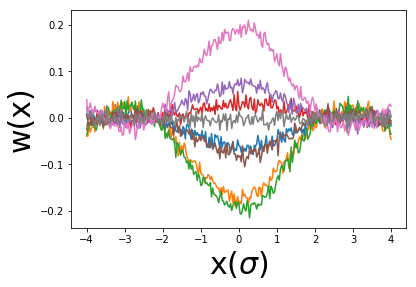

In [29]:
x = np.linspace(-LLw,LLw,Lw)*dx
for j in range (Nw):
    plt.plot(x,w[j],label="w"+str(j))
#plt.title("w")
plt.ylabel("w(x)",size=30)
plt.xlabel("x($\sigma$)",size=30)
#plt.legend() 


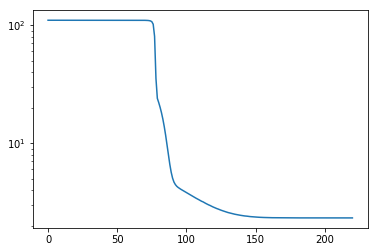

In [30]:
plt.semilogy(error_array)

In [31]:
save_data(w,beta,error_array)

In [32]:
# check dJ/dw ~ (J[w+d]-J[w])/d
'''
np.random.seed(0)
batch_number=np.arange(batch_size)
np.random.shuffle(batch_number)
dbeta = np.zeros((beta.shape))
dw = np.zeros((w.shape))

rhoML_array = np.zeros((mini_batch,N))
rho0ML_array = np.zeros((mini_batch))
n_array = np.zeros([mini_batch,Nw,N])
rhow = np.zeros((mini_batch,Lw,Nw,N))

epco_error = 0
N_minbatch = int(batch_size/mini_batch)
#print("AAA")
for M in range(1):
    print(str(M)+'/'+str(batch_size/mini_batch))
    rho_array,Vext_array,epsilon_array,mu_array=load_data (
        batch_number[M*mini_batch:(M+1)*mini_batch])

    for MM in range(mini_batch):
        for j in range (Nw):
            n_array[MM][j] = conv(rho_array[MM],w[j])

    for MM in range(mini_batch):
        c1 = cal_c1(beta,epsilon_array[MM],n_array[MM],w,
                    rho_array[MM])
        mu_ML=cal_mu_ML(rho_array[MM],c1,Vext_array[MM])
        rho0ML_array[MM]=cal_rho0(mu_ML,w,beta,
                                  epsilon_array[MM])
        rhoML_array[MM] = cal_rho_ML(mu_ML,c1,Vext_array[MM])

    epco_error=error(rho_array,rhoML_array)

    w_new=np.copy(w)
    delta=10**(-5)
    w_new[0][0]+=delta
    
    for MM in range(mini_batch):
        for j in range (Nw):
            n_array[MM][j] = conv(rho_array[MM],w_new[j])

    for MM in range(mini_batch):
        c1 = cal_c1(beta,epsilon_array[MM],n_array[MM],w_new,
                    rho_array[MM])
        mu_ML=cal_mu_ML(rho_array[MM],c1,Vext_array[MM])
        #print(mu_array[MM],mu_ML)
        #mu_array[MM]=np.log(np.sum(rho_array[MM])/np.sum(np.exp(-c1-Vext_array[MM])))
        rho0ML_array[MM]=cal_rho0(mu_ML,w_new,beta,
                                  epsilon_array[MM])
        rhoML_array[MM] = cal_rho_ML(mu_ML,c1,Vext_array[MM])

    epco_error_new=error(rho_array,rhoML_array)
    
    for i in range(Nw):
        for j in range(Nw):
            dbeta[i][j] = Dbeta_tot(rhoML_array,rho_array,rho0ML_array
                                    ,epsilon_array,n_array,w,i,j)
            #print(dbeta[i][j])

    for i in range(mini_batch):
        rhow[i]=kernel_rhow(n_array[i],w)

    for j in range(Nw):
        for p in range(Lw):
            dw[j][p]=Dw_tot(rhoML_array,rho_array,rho0ML_array,rhow,j,p,beta,epsilon_array,w)
    print( (epco_error_new- epco_error)/delta,dw[0][0])
'''
print()